## Lab Work 2 : Linear Regression

This notebook builds on the second lecture of Foundations of Machine Learning. We'll focus on the linear regression model.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

## Introduction

In this sequence, we are trying to predict the price of the stock TSM : a taiwanese manufacturer of GPU chips, mostly used nowadays in AI. Let's have a look at the features we have to do it.

In [2]:
import pandas as pd

df = pd.read_csv("TSM.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.head()


,TSM,NVDA,MU,Gold,Silver,Platinium,Paladium,Copper
Date,,,,,,,,
2010-01-04,7.298709,0.423830,10.597220,1117.699951,17.440001,1517.300049,419.799988,3.3880
2010-01-05,7.267193,0.430019,10.909765,1118.099976,17.781000,1530.800049,420.350006,3.3960
2010-01-06,7.241982,0.432770,10.958601,1135.900024,18.163000,1552.199951,425.600006,3.4775
2010-01-07,7.002473,0.424289,10.587452,1133.099976,18.333000,1553.000000,422.950012,3.4115
2010-01-08,6.996171,0.425206,10.841397,1138.199951,18.458000,1564.599976,424.149994,3.3880


All of the above data comes from the [Yahoo Finance Python API](https://github.com/ranaroussi/yfinance). It gives access to all finance market data live listed on [Yahoo Finance](https://fr.finance.yahoo.com/). We choosed the daily close price of :
* **Companies** : Taiwan Semiconductor Manufacturing ([TSM](https://finance.yahoo.com/quote/TSM/)), Nvidia ([NVDA](https://finance.yahoo.com/quote/NVDA/)) and Micron Technology ([MU](https://finance.yahoo.com/quote/MU/))
* **Comodities** : Gold, Silver, Platinium, Paladium and Coppper. We couldn't get the silicon price because it is not freely available.

Our hypothese is that theses tickers can help use predict TSM's stock price. Let's have a look first at his price through time :



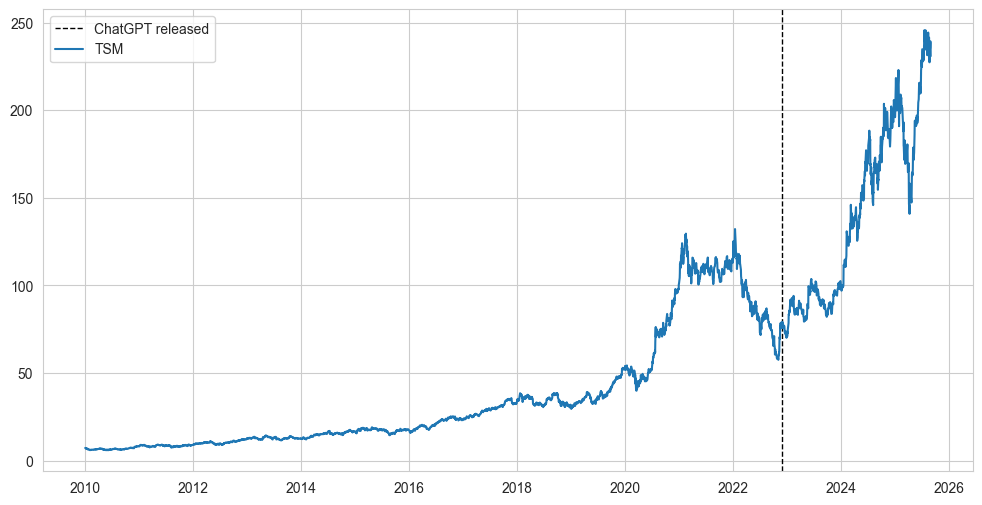

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.axvline(x=pd.to_datetime("2022-11-30"), ls='--', color="black", label="ChatGPT released", lw=1)
plt.plot(df["TSM"], label="TSM")
plt.legend()
plt.show()

## Data exploration

We need to go a bit deeper.

**Task** : Use the [`scatter_matrix`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html) function to start exploration relationship between all the columns.

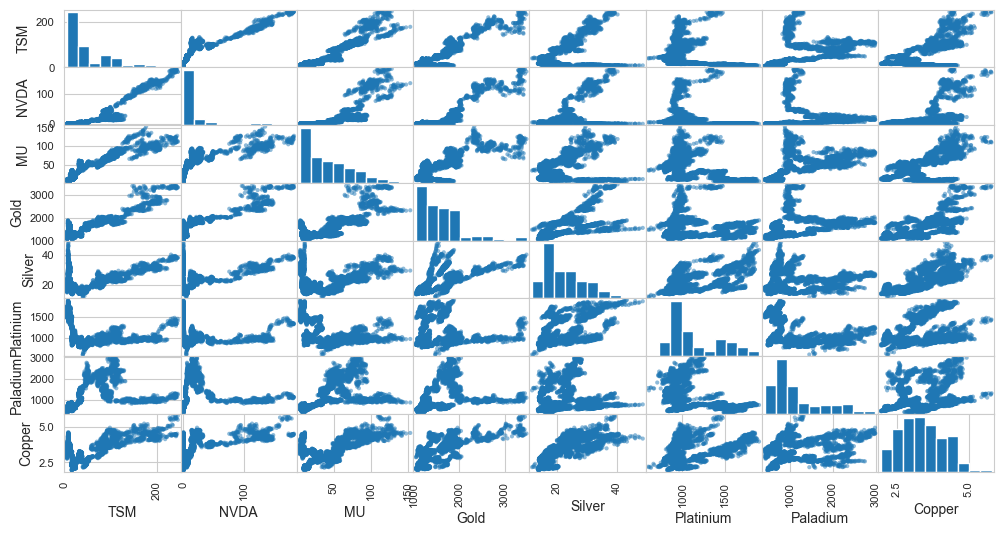

In [4]:
pd.plotting.scatter_matrix(df, figsize=(12, 6))
plt.show()

**Task** : Use the [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function with the [`corr`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) method on the dataframe and plot the result.

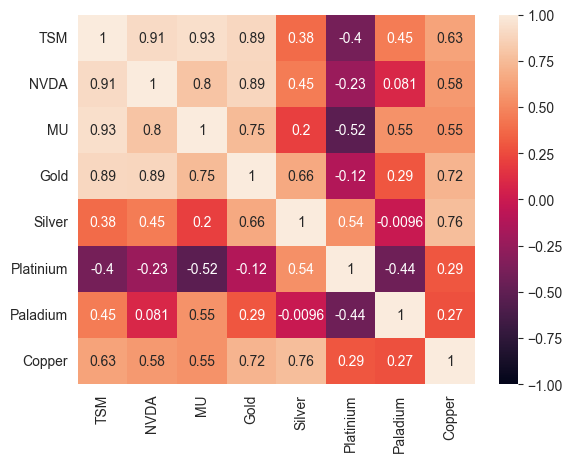

In [5]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

**Task** : Given the previous cells, make a choice on which columns to keep.

In [6]:
columns_to_keep = df.columns[(df.corr()["TSM"] > 0.5)]
df = df[columns_to_keep]
df.head()

,TSM,NVDA,MU,Gold,Copper
Date,,,,,
2010-01-04,7.298709,0.423830,10.597220,1117.699951,3.3880
2010-01-05,7.267193,0.430019,10.909765,1118.099976,3.3960
2010-01-06,7.241982,0.432770,10.958601,1135.900024,3.4775
2010-01-07,7.002473,0.424289,10.587452,1133.099976,3.4115
2010-01-08,6.996171,0.425206,10.841397,1138.199951,3.3880


## Feature engineering

Before we continue, we need to split the training and test set. In our setup, doing it randomly with [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) will lead to data leakage. Indeed, we might train on future data and test on data from the past, so we need to split according to time.

**Task** : Define a `train_test_time_splitting` function that split a matrix of feature *X* and a target vector *y* according to a *train_ratio*. 


In [7]:
def train_test_time_splitting(X, y, train_ratio=0.75):
    index = int(df.shape[0] * train_ratio)
    X_train, y_train = X.iloc[:index], y[:index]
    X_test, y_test = X.iloc[index:], y[index:]
    return X_train, X_test, y_train, y_test

Now we need to build time series specific features. As we have daily closing price, we can't used them to predict *directly*. Instead, we can compute features based on the past values :

* **Lags** : the last value for a given period. One can use the [`shift`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) method for a vector.
* **Rolling** : the average or standard deviation of the previous values for a given period. One can use the [`rolling`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) method for a vector alongside the `mean` and `std` functions.
* **Return** : the evolution across a given period. One can use the [`pct_change`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) method for a vector.

**Task** : Define a function that build lags, rolling and return features (each being optionnal) for a dataframe and specifics columns. Also specify the periods length.



In [8]:
def add_lag_rolling_features(df, columns, values, lags=True, rolling_avg=True, rolling_std=True, pct_change=True):
    for column in columns:
        for value in values:
            if lags: df[f"{column}_lag{value}"] = df[column].shift(periods=value)
            if rolling_avg: df[f"{column}_rolling_avg{value}"] = df[column].rolling(window=value).mean()
            if rolling_std: df[f"{column}_rolling_std{value}"] = df[column].rolling(window=value).std()
            if pct_change: df[f"{column}_return{value}"] = df[column].pct_change(periods=value)
    return df

**Task** : Use the previous function to compute rolling features of your choice.

In [118]:
columns = ["TSM", "NVDA", "MU", "Gold", "Copper"]
df = add_lag_rolling_features(df, columns=columns, values=[7, 14, 28], lags=False, rolling_std=False, pct_change=False)
df = df.dropna()
df.tail()

,TSM,NVDA,MU,Gold,Copper,TSM_rolling_avg7,TSM_rolling_avg14,TSM_rolling_avg28,NVDA_rolling_avg7,NVDA_rolling_avg14,...,MU_rolling_avg28,Gold_rolling_avg7,Gold_rolling_avg14,Gold_rolling_avg28,Copper_rolling_avg7,Copper_rolling_avg14,Copper_rolling_avg28,NVDA_rolling_avg7_sqrt,NVDA_rolling_avg14_sqrt,NVDA_rolling_avg28_sqrt
Date,,,,,,,,,,,,,,,,,,,,,
2025-08-25,235.589996,179.799866,116.419998,3373.800049,4.4665,233.928574,233.434288,223.573013,178.029957,171.098922,...,120.150460,3344.228516,3334.849958,3346.199977,4.445071,4.675321,4.767500,13.342787,13.410705,13.310764
2025-08-26,238.720001,181.759750,116.500000,3388.600098,4.4505,233.905716,234.159288,224.797567,178.218519,172.814539,...,120.437677,3351.742815,3343.057111,3348.553554,4.441143,4.631179,4.753946,13.349851,13.416961,13.322524
2025-08-27,239.289993,181.589767,117.750000,3404.600098,4.4145,233.602857,235.073572,225.977715,178.159954,174.500873,...,120.684261,3362.157122,3350.928554,3351.142840,4.435071,4.587214,4.736268,13.347657,13.419170,13.334835
2025-08-28,238.270004,180.159836,122.000000,3431.800049,4.4635,234.398573,236.044288,226.927144,178.807059,176.420049,...,120.968809,3379.071429,3357.721418,3355.103559,4.442857,4.545464,4.721250,13.371876,13.412435,13.346600
2025-08-29,230.869995,174.170166,119.010002,3473.699951,4.5185,234.722857,235.849287,227.553929,178.632782,177.629266,...,121.079134,3397.685721,3366.699986,3360.546413,4.456071,4.500429,4.711161,13.365358,13.391438,13.356163


## Modelisation

Let's recap what we have learned so far, including the previous session :
1. A linear regression needs its input to be float and standardized : we use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to this end
2. It is easier to wrap the previous step with learning using a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
3. We need to split the dataset into train and test set according to time, using our own `train_test_time_splitting` function
4. We shall have a way to compare our work to a strong baseline. Here we will take the rolling average of TSM stock value in the last 7 days.


Common metrics to assess the performance of a regressor are, given a dataset of $n$ sample, ground truth vector $y$ and predicted values vector $\hat{y}$:
* **Root Mean Square Error** ([`RMSE`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html)) : penalize more large errors than MAE
$$ RMSE(y, \hat{y}) = \sqrt{\frac{1}{n} \sum_{k=1}^n (y_k - \hat{y}_k)^2}$$

* **Mean Absolute Error** ([`MAE`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)) : penalize smaller errors more than RMSE, all errors *weights* the same
$$ MAE(y, \hat{y}) = \frac{1}{n}\sum_{k=1}^n \left|y_k - \hat{y}_k\right|$$

* **[$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) Score** : bounded above by 1, gives insights on how well the model grasps the *structure*. Note that $R^2$ can be negative.
$$ R^2(y, \hat{y}) = 1 - \frac{\displaystyle \sum_{k=1}^n (y_k - \hat{y_k})^2}{\displaystyle \sum_{k=1}^n (y_k - \overline{y})^2}$$


**Task** : Define a function that takes a dataset with features, the target column and the features columns. Then the function will split, train and display performance on the test according to the three above metrics, and display the performance of the baseline.

In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

def experiment_ticker(df, ticker, columns_to_keep=None):
    if columns_to_keep is None:
        columns_to_keep = [column for column in df.columns if ("_" in column)]
    
    X = df[columns_to_keep]
    y = df[ticker]

    X_train, X_test, y_train, y_test = train_test_time_splitting(X, y)
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ])

    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics = {
        "ticker": ticker,

        "RMSE_model": root_mean_squared_error(y_true=y_test, y_pred=y_pred),
        "RMSE_rolling_avg7": root_mean_squared_error(y_true=y_test, y_pred=X_test[f"{ticker}_rolling_avg7"]),

        "MAE_model": mean_absolute_error(y_true=y_test, y_pred=y_pred),
        "MAE_rolling_avg7": mean_absolute_error(y_true=y_test, y_pred=X_test[f"{ticker}_rolling_avg7"]),

        "R2_model": r2_score(y_true=y_test, y_pred=y_pred),
        "R2_rolling_avg7": r2_score(y_true=y_test, y_pred=X_test[f"{ticker}_rolling_avg7"])
    }

    return metrics

**Task** : use this function for our purpose using only TSM and NVDA rolling avg features.

In [125]:
experiment_ticker(df, "TSM", columns_to_keep=[
    "TSM_rolling_avg7", "TSM_rolling_avg14", "TSM_rolling_avg28",
    "NVDA_rolling_avg7", "NVDA_rolling_avg14", "NVDA_rolling_avg28"])

{'ticker': 'TSM',
 'RMSE_model': 4.530937631394651,
 'RMSE_rolling_avg7': 4.096953874001875,
 'MAE_model': 3.18002741195034,
 'MAE_rolling_avg7': 2.9743294018588404,
 'R2_model': 0.9893412734273691,
 'R2_rolling_avg7': 0.9912853228608647}

Our model performs worse than the rolling average baseline, yet showing great metric performance. We need to improve our model.

## Doing better

**Task** : Run the following cell and analyze its output.

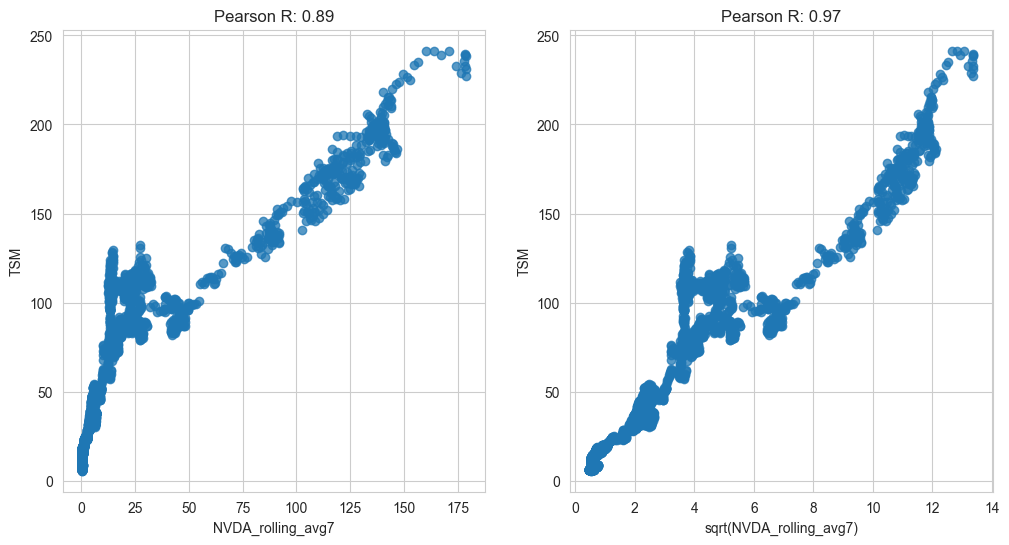

In [124]:
import numpy as np
from scipy.stats import pearsonr

column = "NVDA_rolling_avg7"
function = np.sqrt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df[column], df["TSM"], alpha=0.75)
plt.xlabel(column)
plt.ylabel("TSM")
results = pearsonr(x=df[column], y=df["TSM"])
plt.title(f"Pearson R: {results.correlation:0.2f}")

plt.subplot(1, 2, 2)
plt.scatter(function(df[column]), df["TSM"], alpha=0.75)
plt.xlabel(f"{function.__name__}({column})")
plt.ylabel("TSM")
results = pearsonr(x=function(df[column]), y=df["TSM"])
plt.title(f"Pearson R: {results.correlation:0.2f}")

plt.show()

We see that the trend between TSM stock closing price and NVDA's are not linearly related, but they are with a root square ! Therefore, to *help* the linear model, we shall switch from *pure* NVDA's stock values to square root values. Obviously, one need to check that it works with all rolling average column related to NVIDIA.

**Task** : Implement the described idea. Then, train again a model using these features.

In [126]:
for column in ["NVDA_rolling_avg7", "NVDA_rolling_avg14", "NVDA_rolling_avg28"]:
    df[f"{column}_sqrt"] = np.sqrt(df[column])

experiment_ticker(df, "TSM", columns_to_keep=[
    "TSM_rolling_avg7", "TSM_rolling_avg14", "TSM_rolling_avg28",
    "NVDA_rolling_avg7_sqrt", "NVDA_rolling_avg14_sqrt", "NVDA_rolling_avg28_sqrt"])

{'ticker': 'TSM',
 'RMSE_model': 3.7452814221103927,
 'RMSE_rolling_avg7': 4.096953874001875,
 'MAE_model': 2.7340006985595218,
 'MAE_rolling_avg7': 2.9743294018588404,
 'R2_model': 0.9927172053273607,
 'R2_rolling_avg7': 0.9912853228608647}

Now, this is better !

**Task** : Keep trying ideas to outperform even more the baseline.